In [1]:
import numpy as np
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

print("Imports loaded successfully.")

2025-04-10 23:31:40.123046: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 23:31:40.127649: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 23:31:40.222431: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 23:31:40.277493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 23:31:40.371995: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

Imports and helper functions loaded successfully.


In [2]:
# Load Model and Data
try:
    # Load the newly trained model
    model = load_model('models/convlstm_final_v4.keras')
    print("Model loaded successfully.")

    # Load the new scaler
    scaler = joblib.load('data/scaler.pkl')  # Use the new scaler file
    print("Scaler loaded successfully.")
    print(f"Scaler n_features_in_: {scaler.n_features_in_}")  # Debug scaler fitted shape

    # Load test data
    X_test = np.load('data/X_test.npy')
    y_test = np.load('data/y_test.npy')
    print(f"Test data loaded - X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # Verify shapes match
    if X_test.shape[1:] != (24, 11, 33, 9) or y_test.shape[1:] != (11, 33, 9):
        print("Warning: Input or output shapes do not match expected (24, 11, 33, 9) or (11, 33, 9). Check preprocessing.")
    else:
        print("Shapes verified.")

    # Define variables order (must match reprocessing)
    variables = ['d2m', 't2m', 'sp', 'u10', 'v10', 'tcc', 'cp', 'lsp', 'tp']
    n_vars = len(variables)

    # Define indices for key variables
    temp_idx = variables.index('t2m')    # Temperature
    sp_idx = variables.index('sp')       # Surface pressure
    precip_idx = variables.index('tp')   # Precipitation
    cloud_idx = variables.index('tcc')   # Cloud cover
    u_wind_idx = variables.index('u10')  # U wind component
    v_wind_idx = variables.index('v10')  # V wind component
    dewpoint_idx = variables.index('d2m') # Dewpoint (same as d2m)

except Exception as e:
    print(f"Error loading model or data: {e}")

Model loaded successfully.
Scaler loaded successfully.
Scaler n_features_in_: 9
Test data loaded - X_test shape: (5236, 24, 11, 33, 9), y_test shape: (5236, 11, 33, 9)
Shapes verified.


In [71]:
# Save as .h5
model.save("convlstm_final_v4.h5")

print("Model converted and saved as .h5 successfully!")

Model converted and saved as .h5 successfully!


In [3]:
# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

I0000 00:00:1743549128.561263   17075 service.cc:152] XLA service 0x7f13c0008590 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743549128.561338   17075 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-04-02 01:12:08.645016: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743549129.169022   17075 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Test Loss (MSE): 0.0023
Test MAE: 0.0212


In [4]:
try:
    # Predict on test data
    predictions = model.predict(X_test, verbose=1)
    print(f"Predictions made - Shape: {predictions.shape}")

    # Check pre-transformation output statistics (normalized, 0-1 range)
    print("Pre-transformation output statistics (normalized, 0-1 range):")
    for var, idx in [('temperature', temp_idx), ('surface_pressure', sp_idx), ('precipitation', precip_idx), ('cloud_cover', cloud_idx)]:
        var_min = np.min(predictions[..., idx])
        var_max = np.max(predictions[..., idx])
        var_mean = np.mean(predictions[..., idx])
        print(f"{var.capitalize()} - Min: {var_min:.4f}, Max: {var_max:.4f}, Mean: {var_mean:.4f}")

    # Clip invalid values to [0, 1] for precipitation and cloud cover (optional fix)
    predictions[..., precip_idx] = np.clip(predictions[..., precip_idx], 0, 1)
    predictions[..., cloud_idx] = np.clip(predictions[..., cloud_idx], 0, 1)
    print("Clipped precipitation and cloud cover to [0, 1] range.")

    # Inverse transform predictions and ground truth to original scale
    n_samples = predictions.shape[0]  # 5236
    n_lat, n_lon = predictions.shape[1], predictions.shape[2]  # 11, 33
    n_pixels = n_lat * n_lon  # 363
    n_vars = predictions.shape[3]  # 9

    # Flatten to (n_samples * n_lat * n_lon, n_vars)
    pred_flat = predictions.reshape(n_samples * n_pixels, n_vars)
    y_test_flat = y_test.reshape(n_samples * n_pixels, n_vars)
    print(f"Flattened pred shape: {pred_flat.shape}")  # Should be (1,900,068, 9)
    print(f"Flattened y_test shape: {y_test_flat.shape}")  # Should be (1,900,068, 9)

    # Inverse transform all variables together
    predictions_orig_flat = scaler.inverse_transform(pred_flat)
    y_test_orig_flat = scaler.inverse_transform(y_test_flat)
    print(f"Inverse transformed pred shape: {predictions_orig_flat.shape}")  # Should be (1,900,068, 9)

    # Reshape back to original
    predictions_orig = predictions_orig_flat.reshape(n_samples, n_lat, n_lon, n_vars)
    y_test_orig = y_test_orig_flat.reshape(n_samples, n_lat, n_lon, n_vars)
    print(f"Reshaped predictions_orig shape: {predictions_orig.shape}")  # Should be (5236, 11, 33, 9)

    print("Predictions and ground truth inverse transformed successfully.")

    # Debug: Check a sample temperature value
    sample_idx = 0
    print(f"Sample {sample_idx} raw temp (normalized): {predictions[sample_idx, 0, 0, temp_idx]:.4f}")
    print(f"Sample {sample_idx} transformed temp (Kelvin): {predictions_orig[sample_idx, 0, 0, temp_idx]:.2f}K")

except Exception as e:
    print(f"Error during prediction: {e}")

I0000 00:00:1744320802.210082   21361 service.cc:146] XLA service 0x7fadbc007de0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744320802.210146   21361 service.cc:154]   StreamExecutor device (0): Host, Default Version
2025-04-10 23:33:22.260212: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744320802.463509   21361 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


164/164 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step   
Predictions made - Shape: (5236, 11, 33, 9)
Pre-transformation output statistics (normalized, 0-1 range):
Temperature - Min: 0.0995, Max: 0.9742, Mean: 0.6187
Surface_pressure - Min: 0.0352, Max: 1.0115, Mean: 0.6729
Precipitation - Min: -0.0582, Max: 0.6057, Mean: 0.0103
Cloud_cover - Min: -0.2267, Max: 1.2130, Mean: 0.6472
Clipped precipitation and cloud cover to [0, 1] range.
Flattened pred shape: (1900668, 9)
Flattened y_test shape: (1900668, 9)
Inverse transformed pred shape: (1900668, 9)
Reshaped predictions_orig shape: (5236, 11, 33, 9)
Predictions and ground truth inverse transformed successfully.
Sample 0 raw temp (normalized): 0.6657
Sample 0 transformed temp (Kelvin): 288.00K


In [8]:
# MAE for each Variable 
mae_values = []
for i, var in enumerate(variables):
    # Flatten the Dimensions except der Variable-Dimension
    y_test_var = y_test_orig[:, :, :, i].flatten()
    y_pred_var = predictions_orig[:, :, :, i].flatten()
    mae = mean_absolute_error(y_test_var, y_pred_var)
    mae_values.append(mae)

# Print MAE
for var, mae in zip(variables, mae_values):
    print(f"MAE für {var}: {mae:.4f}")

MAE für d2m: 0.8257
MAE für t2m: 0.7627
MAE für sp: 4.3376
MAE für u10: 0.3198
MAE für v10: 0.5239
MAE für tcc: 0.0929
MAE für cp: 0.1175
MAE für lsp: 0.0820
MAE für tp: 0.1409


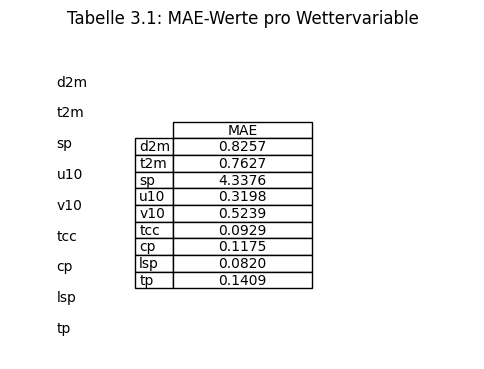

In [7]:
# Data for Table
data = [[var, f"{mae:.4f}"] for var, mae in zip(variables, mae_values)]
col_labels = ['Wettervariable', 'MAE']
row_labels = [row[0] for row in data]
table_vals = [[row[1]] for row in data]  # Nur MAE-Werte für die zweite Spalte

# plot Table
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')  # Keine Achsen anzeigen
table = ax.table(cellText=table_vals,
                 rowLabels=row_labels,
                 colLabels=col_labels[1:],  # Nur 'MAE' als Spaltenüberschrift
                 loc='center',
                 cellLoc='center',
                 colWidths=[0.3])

# label rows
for i, label in enumerate(row_labels):
    ax.text(0.1, 0.9 - i * 0.1, label, ha='left', va='center', transform=ax.transAxes)

# Titel
plt.title('Tabelle 3.1: MAE-Werte pro Wettervariable', pad=20)

# Speichern als Bild
plt.savefig('mae_table.png', bbox_inches='tight', dpi=300)
plt.show()

In [9]:
# Verify Unit Conversion
try:
    # Convert a sample temperature to Celsius for verification
    sample_temp_k = predictions_orig[0, 0, 0, temp_idx]  # First pixel of first sample
    sample_temp_c = kelvin_to_celsius(sample_temp_k)
    print(f"Sample temperature in Kelvin: {sample_temp_k:.2f}K")
    print(f"Sample temperature in Celsius: {sample_temp_c:.2f}°C")

    # Check if temperature is realistic (should be -10°C to 30°C for your region)
    if sample_temp_c < -273 or sample_temp_c > 40:
        print("Warning: Temperature value is unrealistic. Check scaler or inverse transform.")
    else:
        print("Temperature conversion appears valid.")

except Exception as e:
    print(f"Error verifying unit conversion: {e}")

Sample temperature in Kelvin: 288.00K
Sample temperature in Celsius: 14.85°C
Temperature conversion appears valid.


In [12]:
# Setup Cartopy and Define Coordinates

# Define latitude and longitude from your dataset
latitudes = np.linspace(46.5, 49.0, 11)  # 11 points from 46.5 to 49.0
longitudes = np.linspace(9.5, 17.5, 33)  # 33 points from 9.5 to 17.5
lon, lat = np.meshgrid(longitudes, latitudes)

print("Cartopy and coordinates set up successfully.")

Cartopy and coordinates set up successfully.


In [27]:
# Select a Random Timestep
import numpy as np

# Select a random sample index from the test set
sample_idx = np.random.randint(0, y_test.shape[0])  # Random index between 0 and 5235
print(f"Selected random timestep index: {sample_idx}")

# Extract actual and predicted values for this sample
actual_sample = y_test_orig[sample_idx]  # Shape: (11, 33, 9)
pred_sample = predictions_orig[sample_idx]  # Shape: (11, 33, 9)

# Define indices and extract variables
temp_idx = variables.index('t2m')
sp_idx = variables.index('sp')
precip_idx = variables.index('tp')
cloud_idx = variables.index('tcc')

t2m_true = actual_sample[..., temp_idx]
t2m_pred = pred_sample[..., temp_idx]
sp_true = actual_sample[..., sp_idx]
sp_pred = pred_sample[..., sp_idx]
tp_true = actual_sample[..., precip_idx]
tp_pred = pred_sample[..., precip_idx]
cloud_true = actual_sample[..., cloud_idx]
cloud_pred = pred_sample[..., cloud_idx]

Selected random timestep index: 5235


In [24]:
from datetime import datetime, timedelta

start_date = datetime(2024, 5, 26, 0, 0)  # 1. Januar 2025, 00:00
index = sample_idx
hours = index  # Jeder Index = 1 Stunde

target_date = start_date + timedelta(hours=hours)
print(f"Timestep {index} entspricht: {target_date}")

Timestep 1104 entspricht: 2024-07-11 00:00:00


In [23]:
# Find High Precipitation Samples (select this or random timestep)
# Extract precipitation across all test samples
tp_true_all = y_test_orig[..., precip_idx]  # Shape: (5236, 11, 33)
tp_pred_all = predictions_orig[..., precip_idx]  # Shape: (5236, 11, 33)
pred_threshold = 11

# Find samples with significant precipitation (threshold > pred_threshold mm)
high_precip_idx = np.where(np.any(tp_true_all > pred_threshold, axis=(1, 2)))[0]  # Indices of samples with any pixel > 2 mm
if len(high_precip_idx) > 0:
    sample_idx = high_precip_idx[0]  # Select the first high-precipitation sample
    print(f"Found {len(high_precip_idx)} samples with precipitation > {pred_threshold} mm. Using sample index: {sample_idx}")
else:
    sample_idx = np.random.randint(0, y_test.shape[0])  # Fallback to random sample if none found
    print(f"No samples with precipitation > {pred_threshold} mm found. Using random sample index: {sample_idx}")

# Extract actual and predicted values for this sample
actual_sample = y_test_orig[sample_idx]  # Shape: (11, 33, 9)
pred_sample = predictions_orig[sample_idx]  # Shape: (11, 33, 9)

# Define indices and extract variables
temp_idx = variables.index('t2m')
sp_idx = variables.index('sp')
precip_idx = variables.index('tp')
cloud_idx = variables.index('tcc')

t2m_true = actual_sample[..., temp_idx]
t2m_pred = pred_sample[..., temp_idx]
sp_true = actual_sample[..., sp_idx]
sp_pred = pred_sample[..., sp_idx]
tp_true = actual_sample[..., precip_idx]
tp_pred = pred_sample[..., precip_idx]
cloud_true = actual_sample[..., cloud_idx]
cloud_pred = pred_sample[..., cloud_idx]

Found 10 samples with precipitation > 11 mm. Using sample index: 1104


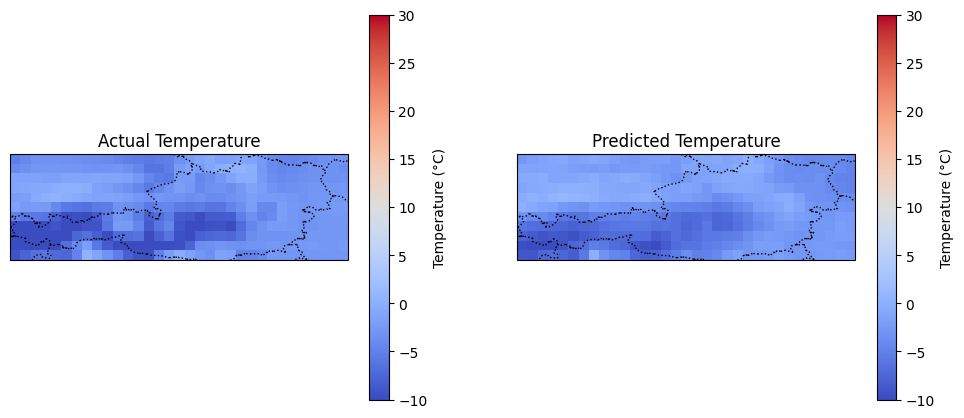

Actual Temp min/max: -13.29/0.61°C
Predicted Temp min/max: -10.86/0.95°C


In [28]:
# Cell 8: Plot Temperature (Actual vs. Predicted with Conversion)
# Convert to Celsius before plotting
t2m_true_c = kelvin_to_celsius(t2m_true)
t2m_pred_c = kelvin_to_celsius(t2m_pred)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
plt.imshow(t2m_true_c, cmap='coolwarm', extent=[9.5, 17.5, 46.5, 49.0], vmin=-10, vmax=30)
plt.colorbar(label='Temperature (°C)')
plt.title("Actual Temperature")
plt.gca().add_feature(cfeature.BORDERS, linestyle=':')
plt.gca().add_feature(cfeature.COASTLINE)
plt.gca().add_feature(cfeature.LAND, edgecolor='black')

plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
plt.imshow(t2m_pred_c, cmap='coolwarm', extent=[9.5, 17.5, 46.5, 49.0], vmin=-10, vmax=30)
plt.colorbar(label='Temperature (°C)')
plt.title("Predicted Temperature")
plt.gca().add_feature(cfeature.BORDERS, linestyle=':')
plt.gca().add_feature(cfeature.COASTLINE)
plt.gca().add_feature(cfeature.LAND, edgecolor='black')

plt.show()

# Debug: Check range
print(f"Actual Temp min/max: {np.min(t2m_true_c):.2f}/{np.max(t2m_true_c):.2f}°C")
print(f"Predicted Temp min/max: {np.min(t2m_pred_c):.2f}/{np.max(t2m_pred_c):.2f}°C")

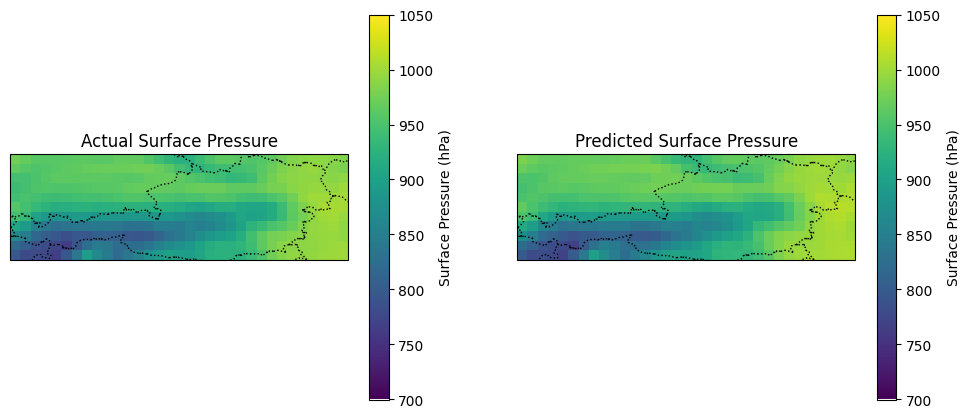

Actual SP min/max: 764.44/1003.38 hPa
Predicted SP min/max: 767.69/1011.82 hPa


In [15]:
# Plot Surface Pressure (Actual vs. Predicted)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
plt.imshow(sp_true, cmap='viridis', extent=[9.5, 17.5, 46.5, 49.0], vmin=700, vmax=1050)
plt.colorbar(label='Surface Pressure (hPa)')
plt.title("Actual Surface Pressure")
plt.gca().add_feature(cfeature.BORDERS, linestyle=':')
plt.gca().add_feature(cfeature.COASTLINE)
plt.gca().add_feature(cfeature.LAND, edgecolor='black')

plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
plt.imshow(sp_pred, cmap='viridis', extent=[9.5, 17.5, 46.5, 49.0], vmin=700, vmax=1050)
plt.colorbar(label='Surface Pressure (hPa)')
plt.title("Predicted Surface Pressure")
plt.gca().add_feature(cfeature.BORDERS, linestyle=':')
plt.gca().add_feature(cfeature.COASTLINE)
plt.gca().add_feature(cfeature.LAND, edgecolor='black')

plt.show()

# Check range
print(f"Actual SP min/max: {np.min(sp_true):.2f}/{np.max(sp_true):.2f} hPa")
print(f"Predicted SP min/max: {np.min(sp_pred):.2f}/{np.max(sp_pred):.2f} hPa")

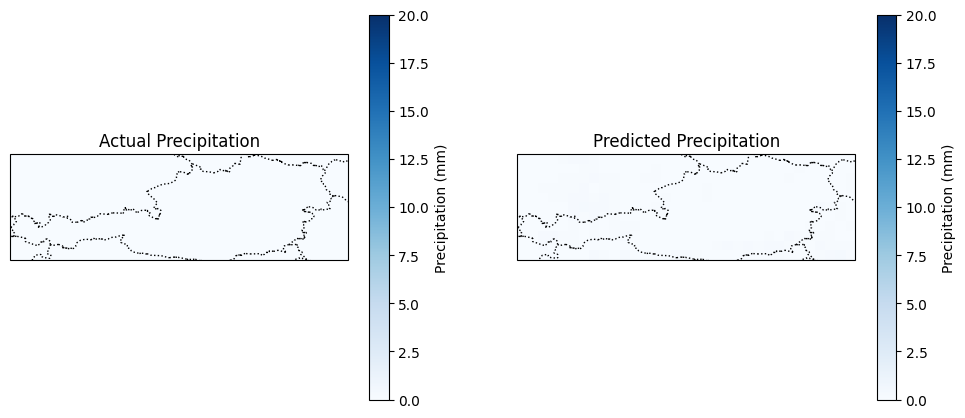

Actual Precip min/max: 0.00/0.04 mm
Predicted Precip min/max: 0.00/0.28 mm


In [29]:
# Cell 10: Plot Precipitation (Actual vs. Predicted)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
plt.imshow(tp_true, cmap='Blues', extent=[9.5, 17.5, 46.5, 49.0], vmin=0, vmax=20)
plt.colorbar(label='Precipitation (mm)')
plt.title("Actual Precipitation")
plt.gca().add_feature(cfeature.BORDERS, linestyle=':')
plt.gca().add_feature(cfeature.COASTLINE)
plt.gca().add_feature(cfeature.LAND, edgecolor='black')

plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
plt.imshow(tp_pred, cmap='Blues', extent=[9.5, 17.5, 46.5, 49.0], vmin=0, vmax=20)
plt.colorbar(label='Precipitation (mm)')
plt.title("Predicted Precipitation")
plt.gca().add_feature(cfeature.BORDERS, linestyle=':')
plt.gca().add_feature(cfeature.COASTLINE)
plt.gca().add_feature(cfeature.LAND, edgecolor='black')

plt.show()

# Debug: Check range
print(f"Actual Precip min/max: {np.min(tp_true):.2f}/{np.max(tp_true):.2f} mm")
print(f"Predicted Precip min/max: {np.min(tp_pred):.2f}/{np.max(tp_pred):.2f} mm")

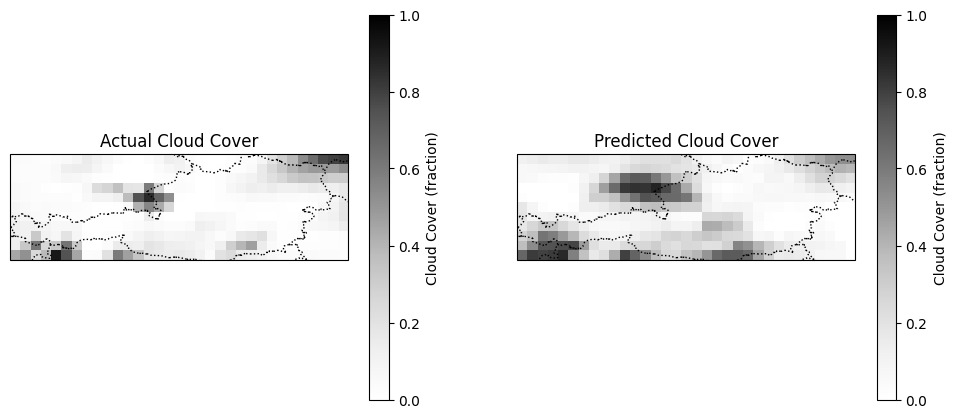

Actual Cloud min/max: 0.00/0.92
Predicted Cloud min/max: 0.00/0.88


In [19]:
# Cell 11: Plot Cloud Cover (Actual vs. Predicted)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
plt.imshow(cloud_true, cmap='Greys', extent=[9.5, 17.5, 46.5, 49.0], vmin=0, vmax=1)
plt.colorbar(label='Cloud Cover (fraction)')
plt.title("Actual Cloud Cover")
plt.gca().add_feature(cfeature.BORDERS, linestyle=':')
plt.gca().add_feature(cfeature.COASTLINE)
plt.gca().add_feature(cfeature.LAND, edgecolor='black')

plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
plt.imshow(cloud_pred, cmap='Greys', extent=[9.5, 17.5, 46.5, 49.0], vmin=0, vmax=1)
plt.colorbar(label='Cloud Cover (fraction)')
plt.title("Predicted Cloud Cover")
plt.gca().add_feature(cfeature.BORDERS, linestyle=':')
plt.gca().add_feature(cfeature.COASTLINE)
plt.gca().add_feature(cfeature.LAND, edgecolor='black')

plt.show()

# Debug: Check range
print(f"Actual Cloud min/max: {np.min(cloud_true):.2f}/{np.max(cloud_true):.2f}")
print(f"Predicted Cloud min/max: {np.min(cloud_pred):.2f}/{np.max(cloud_pred):.2f}")